# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import scipy
import copy
import sys
sys.path.insert(1, '/home/abha2208/py_mesa_reader-master')
import mesa_reader as mr
import scipy.interpolate as sp
from scipy.signal import convolve2d
from scipy.signal import savgol_filter
import pynumdiff

plt.rcParams["mathtext.fontset"] = "cm"


# Constants

In [2]:
#constants

G_const = 6.6743 * pow(10,-8)                 #g^-1 cm^3 s^-2 
M_sun = 1.9891 * pow(10,33)             #g
R_sun = 6.957 * pow(10,10)              #cm
c = 3 * pow(10,10)                      #cm s^-1


#model parameters

M_ns = 1.33 * M_sun                     #g
R_ns = 1000000                          #cm
f0 = 250                                #Hz
omega0 = f0*2*np.pi                     #Hz
e0 = 0.177
p_0 = 1/f0                               #s

eta1 = 1
eta2 = 0.1
alpha_ce = 1
R_eq = 10**6                            #cm
R_const = (8.31 * 10**7) / (6.022 * 10**(23)) #erg/K

#conversions

s_to_yr = 3.17098 * pow(10,-8)
yr_to_s = 3.154 * 10**7
pc_to_cm = 3.086 * pow(10,18)
D = 2.8*1000*pc_to_cm

# General Functions

In [3]:
def multiply_1d_array_to_2d_array(arr1d, arr2d):
    if arr1d.shape[0] != arr2d.shape[0]:
        raise ValueError("The 1D array and 2D array must have the same number of rows.")
    # Reshape the 1D array to have the same number of dimensions as the 2D array
    arr1d_reshaped = arr1d.reshape(-1, 1)
    # Multiply the reshaped 1D array with the 2D array
    result = arr1d_reshaped * arr2d
    return result

def integ1d_trapz(f, x):
    dx = np.diff(x)
    return np.cumsum((f[1:]+f[:-1])*dx/2)

def diff1d(f, x):
    diff = np.array([])
    first = ((2*x[0] - x[1] - x[2]) / ((x[1] - x[0]) * (x[2] - x[0]))) * f[0] + ((x[2] - x[0]) / ((x[1] - x[0]) * (x[2] - x[1]))) * f[1] + ((x[0] - x[1]) / ((x[2] - x[1]) * (x[2] - x[0]))) * f[2]
    between = [(x[1:-1] - x[2:]) / ((x[2:] - x[:-2]) * (x[1:-1] - x[:-2]))] * f[:-2]  +  [(2 * x[1:-1] - x[:-2] - x[2:]) / ((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]))] * f[1:-1]  +  [(x[1:-1] - x[:-2]) / ((x[2:] - x[:-2]) * (x[2:] - x[1:-1]))] * f[2:]
    last = ((x[-1] - x[-2]) / ((x[-1] - x[-3]) * (x[-2] - x[-3]))) * f[-3]  +  ((x[-3] - x[-1]) / ((x[-2] - x[-3]) * (x[-1] - x[-2]))) * f[-2]  +  ((2 * x[-1] - x[-2] - x[-3]) / ((x[-1] - x[-2]) * (x[-1] - x[-3]))) * f[-1]
    diff = np.append(diff, first)
    diff = np.append(diff, between)
    diff = np.append(diff, last)
    return diff

def diff1d_10(f, dx):
    func_arr = np.array([f[:-10], f[1:-9], f[2:-8], f[3:-7], f[4:-6], f[6:-4], f[7:-3], f[8:-2], f[9:-1], f[10:]])
    coeff_arr = np.array([-2,25,-150,600,-2100,2100,-600,150,-25,2])
    diff = multiply_1d_array_to_2d_array(coeff_arr,func_arr)/(2520*dx)
    return np.sum(diff, axis=0)
#(-2*f[:-10] + 25*f[1:-9] - 150*f[2:-8] + 600*f[3:-7] - 2100*f[4:-6] + 2100*f[]

def diff1d_simple_even(f, dx):
    first = (-3*f[0] + 4*f[1] - f[2])/(2*dx)
    between = (f[2:] - f[:-2])/(2*dx)
    last = (f[-3] - 4*f[-2] + 3*f[-1])/(2*dx)
    diff = np.concatenate((np.array([first]), between, np.array([last])))
    return diff

def diff1d_simple_uneven(f, x):
    diff = (f[1:] - f[:-1])/(x[1:] - x[:-1]) 
    return diff

def smoothen(function, window, order, iter = 1):
    i = 1
    smoothed_function = savgol_filter(function, window, order)
    while i < iter:
        smoothed_function = savgol_filter(smoothed_function, window, order)
        i+=1
    return smoothed_function

# Model Functions

In [4]:
def mass_env(rho, a):
    return integ1d_trapz(4*np.pi*rho*(a**2), a)                                  #g

def v_inf(m_env, a, a_num = None):
    v_inf_sq = G_const*(M_ns + m_env)/a                                       #cm^2 s^-2
    if a_num == None:
        return np.sqrt(v_inf_sq)                                      #cm^2 s^-2
    else:
        index = np.where(a >= a_num)
        return np.sqrt(v_inf_sq)[index[0][0]]                           #cm^2 s^-2
    
def back_density_grad(Ra, rho, a):
    return -1*(np.divide(Ra,rho))*diff1d(rho, a)

def drag_hl(Ra, rho, v):
    return np.pi*(Ra**2)*rho*(v**2)

def acc_hl(Ra, rho, v):
    return np.pi*(Ra**2)*rho*v

def drag_ratio_mr15(eps_rho, f1 = 1.91791946, f2 = -1.52814698, f3 = 0.75992092):    
    return f1 + f2*eps_rho + f3*np.power(eps_rho,2)

def acc_rate_ratio_mr15(eps_rho, mu1 = -2.14034214, mu2 = 1.94694764, mu3 = 1.19007536, mu4 = 1.05762477):
    return np.power(10, mu1 + mu2/(1 + mu3*eps_rho + mu4*(eps_rho**2)))

def mdot_edd(opacity):
    return 3.5*(10**(-8))*(M_ns/(1.33*M_sun))*(0.34/opacity)*M_sun/yr_to_s        #g s^-1

def mdot_hyper(opacity):
    return 8.9*(10**(-5))*np.power(opacity/0.34, -0.73)*M_sun/yr_to_s                #g s^-1

def e_orbital(m_env, a):
    return -G_const*M_ns*m_env/(2*a)

def mdot_compare(mdot_mr15, eta, mdot_edd, mdot_hyper):
    mdot = copy.deepcopy(mdot_edd)
    index_btw = np.where(np.logical_or(eta*mdot_mr15 <= mdot_edd, eta*mdot_mr15 >= mdot_hyper))
    if index_btw[0].size > 0:
        mdot[index_btw[0]] = eta*mdot_mr15[index_btw[0]]
    return mdot, index_btw

def e_bind(m_env, a):
    # index = np.where(a >= af)
    dm = np.diff(m_env)
    # indice = np.delete(np.array(index[0]), 0)
    summand = -1*np.divide(G_const*m_env[1:]*dm,a[1:]) #+ 3*R_const*dm*(T[-1] - T[1:])/2
    integral = np.cumsum(summand)                                               
    return integral[-1] - integral

#consider all the variables to be defined from the surface to the core
def orbit_evol(drag, v, a, diff_eorb, i, f):
    integrand = -diff_eorb[i:f]/(drag[i:f]*v[i:f])
    da = np.diff(a[i:f])
    # delta_eorb = eorb[0] - eorb[i:f]
    # index = np.where(delta_eorb[i:] > ebind[i:])
    # print(len(integrand), len(da), index[0][0])
    return np.cumsum((integrand[1:]+integrand[:-1])*da/2)

def acc_mass(mdot, time):
    dt = np.diff(time)
    return np.cumsum((mdot[1:]+mdot[:-1])*dt/2)

def spin_param_from_e(e):
    return 3*(1 - e*np.sqrt(1 - e**2)/np.arcsin(e))/(2*e**2) - 1

def spin_from_e(M, R0, e, n=0.5, kn = 0.81482):
    rho = 3*M/(4*np.pi*R0**3)
    qn = (1-n/5)*kn
    omega_sq = 2*np.pi*G_const*(rho)*(((np.sqrt(1-e**2))*(3-2*e**2)*(np.arcsin(e))/(e**3)) - (3*(1-e**2)/(e**2)))/qn
    return np.sqrt(omega_sq)

def equitorial_radius(R0, e, n = 0.5):
    R_bar = R0*((np.arcsin(e))*((1-e**2)**(1/6))*(1-spin_param_from_e(e))/e)**(-n/(3-n))
    return R_bar/((1-e**2)**(1/6))

#consider the arrays to be defined from t = 0 to t = t_final
def spin_evol(t, mdot, m_acc, omega, e, e0 = 0.177, omega0 = 250*2*np.pi, M_ns = 1.33*M_sun, R_ns = 1000000, m_crust = 0.05*M_sun, n = 0.5, kn = 0.81482):
    omega_evol = np.array([])
    Q_evol = np.array([])
    e_evol = np.array([])
    R_eq_evol = np.array([])
    mom_inrt = np.array([])
    a = np.array([])
    b = np.array([])
    rhs_arr = np.array([])

    tau_melt = 0.05*M_sun/mdot
    Q_max = 4 * 10**(39) * (m_acc/m_crust)
    Q_tb = np.sqrt(5*(c**5)*mdot[0]*np.sqrt(G_const*M_ns*equitorial_radius(R_ns, e0))/(32*G_const*(omega0**5)))
    for i in range(len(t)):
        if i == 0:
            R_eq_evol = np.append(R_eq_evol, equitorial_radius(R_ns, e0))
            Q_evol = np.append(Q_evol, Q_tb)
            omega_evol = np.append(omega_evol, omega0)
            e_evol = np.append(e_evol, e0)
        else:
            Q_tb = np.sqrt(5*(c**5)*mdot[i-1]*np.sqrt(G_const*(M_ns)*equitorial_radius(R_ns, e_evol[i-1]))/(32*G_const*(omega_evol[i-1]**5)))
            if Q_tb > Q_max[i-1]:
                Q_evol = np.append(Q_evol, Q_max[i-1]*np.exp(-t[i-1]/tau_melt[i-1]))
                rhs = mdot[i-1]*np.sqrt(G_const*(M_ns)*R_eq_evol[i-1]) - 32*G_const*(omega_evol[i-1]**5)*(Q_evol[i-1]**2)/(5*(c**5))
                a = np.append(a, R_ns*(1 + e_evol[i-1]/2))
                b = np.append(b, R_ns*(1 - e_evol[i-1]/2))
                mom_inrt = np.append(mom_inrt, (M_ns)*(a[i-1]**2 + b[i-1]**2)/5)
                rhs_arr = np.append(rhs_arr, rhs/mom_inrt[i-1])
                omega_evol = np.append(omega_evol, rhs*(t[i] - t[i-1])/mom_inrt[i-1] + omega_evol[i-1])
                e_evol = np.append(e_evol, np.interp(omega_evol[i], omega, e))
                R_eq_evol = np.append(R_eq_evol, equitorial_radius(R_ns, e_evol[i]))
            else:
                Q_evol = np.append(Q_evol, Q_evol[i-1]*(np.exp(-t[i-1]/tau_melt[i-1])))
                omega_evol = np.append(omega_evol, omega_evol[i-1])
                e_evol = np.append(e_evol, e_evol[i-1])
                R_eq_evol = np.append(R_eq_evol, R_eq_evol[i-1])
    return Q_evol, omega_evol, e_evol, R_eq_evol, mom_inrt, a, b, rhs_arr

            

#all variables start from the surface of the star
def orbit_evol_acc(a, rho, m_env, im_ns, scl_hgt, eta, mdot_hyper, mdot_edd, ns_add = True, f1 = 1.91791946, f2 = -1.52814698, f3 = 0.75992092, mu1 = -2.14034214, mu2 = 1.94694764, mu3 = 1.19007536, mu4 = 1.05762477):
    m_ns = np.array([])
    v = np.array([])
    Ra = np.array([])
    eps_rho = np.array([])

    #drag
    drag_hl = np.array([])
    drag_ratio = np.array([])
    drag_mr15 = np.array([])

    #accretion
    mdot_hl = np.array([])
    mdot_ratio = np.array([])
    mdot_mr15 = np.array([])

    #orbital energy
    eorb = np.array([])
    deorb = np.array([])

    #accretion rate parametrization and drag
    mdot = np.array([])
    drag = np.array([])

    #adding accretion to neutron star
    if ns_add:
        m_ns_acc = np.array([])

    #time
    time = np.array([])

    for i in range(len(a)):
        if i == 0:
            temp_m_ns = im_ns
        else:
            temp_m_ns = m_ns[i-1]
        v = np.append(v, np.sqrt(G_const*(temp_m_ns + m_env[i])/a[i]))
        Ra = np.append(Ra, 2*G_const*temp_m_ns/(v[i]**2))
        eps_rho = np.append(eps_rho, Ra[i]/scl_hgt[i])


        #drag and accretion
        drag_hl = np.append(drag_hl, np.pi*(Ra[i]**2)*rho[i]*(v[i]**2))
        mdot_hl = np.append(mdot_hl, np.pi*(Ra[i]**2)*rho[i]*v[i])

        drag_ratio = np.append(drag_ratio, f1 + f2*eps_rho[i] + f3*pow(eps_rho[i],2))
        mdot_ratio = np.append(mdot_ratio, pow(10, mu1 + mu2/(1 + mu3*eps_rho[i] + mu4*(eps_rho[i]**2))))

        drag_mr15 = np.append(drag_mr15, drag_ratio[i]*drag_hl[i])
        mdot_mr15 = np.append(mdot_mr15, mdot_ratio[i]*mdot_hl[i])


        #orbital energy
        eorb = np.append(eorb, -G_const*temp_m_ns*m_env[i]/(2*a[i]))
        deorb = np.append(deorb, G_const*temp_m_ns*m_env[i]/(2*((a[i])**2)) - G_const*temp_m_ns*np.gradient(m_env)[i]/(2*a[i]*np.gradient(a)[i]))


        #accretion rate parametrization and drag
        if eta*mdot_mr15[i] >= mdot_hyper[i] or eta*mdot_mr15[i] <= mdot_edd[i]:
            mdot = np.append(mdot, eta*mdot_mr15[i])
        else:
            mdot = np.append(mdot, mdot_edd[i])
        drag = np.append(drag, mdot[i]*v[i])

        
        #orbital_evolution
        if i == 0:
            time = np.append(time, 0)
        else:
            temp = np.divide(deorb[:i],(drag[:i])*(v[:i]))
            integral_terms = -(temp[1:i] - temp[0:i-1])*(a[1:i] - a[0:i-1])/2
            time = np.append(time, np.sum(integral_terms))

        if ns_add:
            #mass accreted to neutron star
            if i == 0:
                m_ns_acc = np.append(m_ns_acc, 0)
                m_ns = np.append(m_ns, im_ns)
            else:
                m_ns_acc = np.append(m_ns_acc, mdot[i]*(time[i] - time[i-1]))
                m_ns = np.append(m_ns, m_ns[i-1] + m_ns_acc[i])
        else:
            m_ns = im_ns
        
    return np.array(m_ns), np.array(v), np.array(Ra), np.array(eps_rho), np.array(drag_hl), np.array(drag_ratio), np.array(drag_mr15), np.array(mdot_hl), np.array(mdot_ratio), np.array(mdot_mr15), np.array(eorb), np.array(deorb), np.array(mdot), np.array(drag), np.array(time)
#def quad_mom()

# Load data

In [67]:
#LOAD
hol = mr.MesaData('profiles/12Msun_tipRGB_profile430.data')      #a holgado model
new_M2 = mr.MesaData('profiles/12M_at_520_ex_6.data')            #model of 12 solar mass star with core excised
new_M3 = mr.MesaData('profiles/12M_at_519.data')                 #model of 12 solar mass star without core excised 

In [6]:
#EXTRACT
R_new_M2 = np.flip(R_sun*10**(new_M2.logR))
rho_new_M2 = np.flip(10**(new_M2.logRho))
logR_new_M2 = np.flip(new_M2.logR)
logrho_new_M2 = np.flip(new_M2.logRho)
logT_new_M2 = np.flip(new_M2.logT)
scl_hgt_new_M2 = R_sun*np.flip(new_M2.scale_height)
gradr_new_M2 = np.flip(new_M2.gradr)
etot_new_M2 = np.flip(new_M2.total_energy)
dm_new_M2 = np.flip(new_M2.dm)
etot_int_new_M2 = np.zeros(len(R_new_M2))
for i in range(len(R_new_M2)):
    temp = 0
    for j in range(i):
        temp += etot_new_M2[j]*dm_new_M2[j]
    etot_int_new_M2[i] = temp
etot_int_new_M2 = etot_int_new_M2[-1] - etot_int_new_M2
conv_vel_new_M2 = np.flip(new_M2.conv_vel)
m_new_M2 = M_sun*np.flip(new_M2.q)*new_M2.star_mass
opacity_new_M2 = np.flip(new_M2.opacity)

R_hol = np.flip(R_sun*10**(hol.logR))
rho_hol = np.flip(10**(hol.logRho))
logR_hol = np.flip(hol.logR)
logrho_hol = np.flip(hol.logRho)
logT_hol = np.flip(hol.logT)
scl_hgt_hol = R_sun*np.flip(hol.scale_height)
gradr_hol = np.flip(hol.gradr)
etot_hol = np.flip(hol.total_energy)
etot_int_hol = np.flip(hol.total_energy_integral)
conv_vel_hol = np.flip(hol.conv_vel)
m_hol = M_sun*np.flip(hol.q)*hol.star_mass
opacity_hol = np.flip(hol.opacity)

a = np.array([1,2,3,4,5])
rho = np.array([2,4,6,8,10])
m = mass_env(rho, a)
v = v_inf(m, a[1:])
Ra = 2*G_const*M_ns/(v**2)
eps_rho = back_density_grad(Ra, rho[1:], a[1:])
print(drag_ratio_mr15(rho))

# Evaluation

In [24]:
#EVOLVE
elip = np.linspace(0.001, 0.999, 2000)
omega_from_e = spin_from_e(M_ns, R_ns, elip)
beta_from_e = spin_param_from_e(elip)
beta_sec = np.repeat(0.14, 2000)
factor = 1


#M2

op_new_M2 = np.repeat(0.10, len(R_new_M2))

#eddington and hyper accretion rates
mdot_edd_new_M2 = mdot_edd(op_new_M2)
mdot_hyper_new_M2 = mdot_hyper(op_new_M2) #(10**4)*mdot_edd_new_M2  #

m_der = diff1d(m_new_M2, R_new_M2)

#epsilon rho
v_new_M2 = v_inf(m_new_M2, R_new_M2)
Ra_new_M2 = 2*G_const*M_ns/(v_new_M2**2)
eps_rho_new_M2 = Ra_new_M2/scl_hgt_new_M2

#drag mr15
draghl_new_M2 = drag_hl(Ra_new_M2, rho_new_M2, v_new_M2)
dragratio_new_M2 = drag_ratio_mr15(eps_rho_new_M2)
dragmr15_new_M2 = draghl_new_M2*dragratio_new_M2

#accretion mr15
mdothl_new_M2 = acc_hl(Ra_new_M2, rho_new_M2, v_new_M2)
mdotratio_new_M2 = acc_rate_ratio_mr15(eps_rho_new_M2)
mdotmr15_new_M2 = mdothl_new_M2*mdotratio_new_M2

#orbital energy
eorb_new_M2 = e_orbital(m_new_M2, R_new_M2)
deorb_new_M2 = diff1d(eorb_new_M2, R_new_M2)
delta_eorb_new_M2 = eorb_new_M2[-1] - eorb_new_M2

#accretion rate parametrization
mdot1_new_M2, ind_btw1_new_M2 = mdot_compare(mdotmr15_new_M2, eta1, mdot_edd_new_M2, mdot_hyper_new_M2)
mdot2_new_M2, ind_btw2_new_M2 = mdot_compare(mdotmr15_new_M2, eta2, mdot_edd_new_M2, mdot_hyper_new_M2)

#drag
drag1_new_M2 = eta1*dragmr15_new_M2
drag2_new_M2 = eta2*dragmr15_new_M2
drag_edd_new_M2 = mdot_edd_new_M2*v_new_M2

# print(v_new_M2[-1], mdot2_new_M2[-1], drag2_new_M2[-1], dragmr15_new_M2[-1], mdotmr15_new_M2[-1], mdothl_new_M2[-1], draghl_new_M2[-1], mdot_edd_new_M2[-1], mdot_hyper_new_M2[-1])
 
#sound
sound_speed_sq_new_M2 = diff1d(10**new_M2.logP, 10**new_M2.logRho)
sound_speed_sq_new_M2[np.where(sound_speed_sq_new_M2<0)] = sound_speed_sq_new_M2[np.where(sound_speed_sq_new_M2<0)[0][0]-1]
sound_speed_new_M2 = np.sqrt(sound_speed_sq_new_M2)

#orbital evolution (starts from surface of the star)
# print(len(eorb_new_M2), len(etot_int_new_M2), len(drag1_new_M2), len(v_new_M2), len(R_new_M2), len(deorb_new_M2))
i_new_M2 = 0
f_new_M2 = 1000
t1_new_M2 = orbit_evol(np.flip(drag1_new_M2), np.flip(v_new_M2), np.flip(R_new_M2), np.flip(deorb_new_M2), i_new_M2, f_new_M2)
t2_new_M2 = orbit_evol(np.flip(drag2_new_M2), np.flip(v_new_M2), np.flip(R_new_M2), np.flip(deorb_new_M2), i_new_M2, f_new_M2)
t_edd_new_M2 = orbit_evol(np.flip(drag_edd_new_M2), np.flip(v_new_M2), np.flip(R_new_M2), np.flip(deorb_new_M2), i_new_M2, f_new_M2)

#timescales (starts from surface of the star)
t1_insp_new_M2 = R_new_M2/(np.absolute(drag1_new_M2*v_new_M2/deorb_new_M2))
t2_insp_new_M2 = R_new_M2/(np.absolute(drag2_new_M2*v_new_M2/deorb_new_M2))
t_orb_new_M2 = 2*np.pi*(R_new_M2**1.5)/np.sqrt(G_const*(M_ns + m_new_M2))
insp_param1_new_M2 = t1_insp_new_M2/t_orb_new_M2
insp_param2_new_M2 = t2_insp_new_M2/t_orb_new_M2

#accreted mass (starts from surface of the star)
m_acc1_new_M2 = acc_mass(np.flip(mdot1_new_M2)[i_new_M2+1:f_new_M2], t1_new_M2)
m_acc2_new_M2 = acc_mass(np.flip(mdot2_new_M2)[i_new_M2+1:f_new_M2], t2_new_M2)
m_acc_edd_new_M2 = acc_mass(np.flip(mdot_edd_new_M2)[i_new_M2+1:f_new_M2], t_edd_new_M2)

#quadrupole moment (starts from surface of the star)
qmax1_new_M2 = 4*pow(10,39)*(m_acc1_new_M2/(0.05*M_sun))
qmax2_new_M2 = 4*pow(10,39)*(m_acc2_new_M2/(0.05*M_sun))
qmax_edd_new_M2 = 4*pow(10,39)*(m_acc_edd_new_M2/(0.05*M_sun))

#omega evolution (starts from surface of the star)
Q1_new_M2, omega1_new_M2, e1_new_M2, R_eq1_new_M2, mom_inrt1_new_M2, a1_new_M2, b1_new_M2, rhs1_new_M2 = spin_evol(t1_new_M2, np.flip(mdot1_new_M2)[i_new_M2+1:f_new_M2], m_acc1_new_M2, omega_from_e, elip)
Q2_new_M2, omega2_new_M2, e2_new_M2, R_eq2_new_M2, mom_inrt2_new_M2, a2_new_M2, b2_new_M2, rhs2_new_M2 = spin_evol(t2_new_M2, np.flip(mdot2_new_M2)[i_new_M2+1:f_new_M2], m_acc2_new_M2, omega_from_e, elip)
Q_edd_new_M2, omega_edd_new_M2, e_edd_new_M2, R_eq_edd_new_M2, mom_inrt_edd_new_M2, a_edd_new_M2, b_edd_new_M2, rhs_edd_new_M2 = spin_evol(t_edd_new_M2, np.flip(mdot_edd_new_M2)[i_new_M2+1:f_new_M2], m_acc_edd_new_M2, omega_from_e, elip)

# print(mdot2_new_M2[-1])
# print((mdot2_new_M2[0]+mdot2_new_M2[1])*(t2_new_M2[1] - t2_new_M2[0])/2)
# print(m_acc1_new_M2[0:10])
# print(mdot2_new_M2[0]*(t2_new_M2[1] - t2_new_M2[0]))

#strain amplitude (starts from surface of the star)
h0_edd1_new_M2 = 1.8*10**(-26)# * np.power(omega1_new_M2/np.pi, -1/2)  #2*G_const*(omega_edd_new_M2**2)*Q_edd_new_M2/((c**4)*2800*pc_to_cm)
h0_edd2_new_M2 = 1.8*10**(-26)# * np.power(omega2_new_M2/np.pi, -1/2)
h0_1_new_M2 = 2*G_const*(omega1_new_M2**2)*Q1_new_M2/((c**4)*2800*pc_to_cm)
h0_2_new_M2 = 2*G_const*(omega2_new_M2**2)*Q2_new_M2/((c**4)*2800*pc_to_cm)

###########################################################################################################################################################################
#HOLGADO'S PROFILE

op_hol = np.repeat(0.10, len(R_hol))

#eddington and hyper accretion rates
mdot_edd_hol = mdot_edd(op_hol)
mdot_hyper_hol = mdot_hyper(op_hol) #(10**4)*mdot_edd_hol  #

m_der = diff1d(m_hol, R_hol)

#epsilon rho
v_hol = v_inf(m_hol, R_hol)
Ra_hol = 2*G_const*M_ns/(v_hol**2)
eps_rho_hol = Ra_hol/scl_hgt_hol

#drag mr15
draghl_hol = drag_hl(Ra_hol, rho_hol, v_hol)
dragratio_hol = drag_ratio_mr15(eps_rho_hol)
dragmr15_hol = draghl_hol*dragratio_hol

#accretion mr15
mdothl_hol = acc_hl(Ra_hol, rho_hol, v_hol)
mdotratio_hol = acc_rate_ratio_mr15(eps_rho_hol)
mdotmr15_hol = mdothl_hol*mdotratio_hol

#orbital energy
eorb_hol = e_orbital(m_hol, R_hol)
deorb_hol = diff1d(eorb_hol, R_hol)
delta_eorb_hol = eorb_hol[-1] - eorb_hol

#accretion rate parametrization
mdot1_hol, ind_btw1_hol = mdot_compare(mdotmr15_hol, eta1, mdot_edd_hol, mdot_hyper_hol)
mdot2_hol, ind_btw2_hol = mdot_compare(mdotmr15_hol, eta2, mdot_edd_hol, mdot_hyper_hol)

#drag
drag1_hol = eta1*dragmr15_hol
drag2_hol = eta2*dragmr15_hol
drag_edd_hol = mdot_edd_hol*v_hol
 
#sound
sound_speed_sq_hol = diff1d(10**hol.logP, 10**hol.logRho)
sound_speed_sq_hol[np.where(sound_speed_sq_hol<0)] = sound_speed_sq_hol[np.where(sound_speed_sq_hol<0)[0][0]-1]
sound_speed_hol = np.sqrt(sound_speed_sq_hol)

#orbital evolution (starts from surface of the star)
# print(len(eorb_hol), len(etot_int_hol), len(drag1_hol), len(v_hol), len(R_hol), len(deorb_hol))
i_hol = 0
f_hol = 370
t1_hol = orbit_evol(np.flip(drag1_hol), np.flip(v_hol), np.flip(R_hol), np.flip(deorb_hol), i_hol, f_hol)
t2_hol = orbit_evol(np.flip(drag2_hol), np.flip(v_hol), np.flip(R_hol), np.flip(deorb_hol), i_hol, f_hol)
t_edd_hol = orbit_evol(np.flip(drag_edd_hol), np.flip(v_hol), np.flip(R_hol), np.flip(deorb_hol), i_hol, f_hol)

#timescales (starts from surface of the star)
t1_insp_hol = R_hol/(np.absolute(drag1_hol*v_hol/deorb_hol))
t2_insp_hol = R_hol/(np.absolute(drag2_hol*v_hol/deorb_hol))
t_orb_hol = 2*np.pi*(R_hol**1.5)/np.sqrt(G_const*(M_ns + m_hol))
insp_param1_hol = t1_insp_hol/t_orb_hol
insp_param2_hol = t2_insp_hol/t_orb_hol

#accreted mass (starts from surface of the star)
m_acc1_hol = acc_mass(np.flip(mdot1_hol)[i_hol+1:f_hol], t1_hol)
m_acc2_hol = acc_mass(np.flip(mdot2_hol)[i_hol+1:f_hol], t2_hol)
m_acc_edd_hol = acc_mass(np.flip(mdot_edd_hol)[i_hol+1:f_hol], t_edd_hol)

#quadrupole moment (starts from surface of the star)
qmax1_hol = 4*pow(10,39)*(m_acc1_hol/(0.05*M_sun))
qmax2_hol = 4*pow(10,39)*(m_acc2_hol/(0.05*M_sun))
qmax_edd_hol = 4*pow(10,39)*(m_acc_edd_hol/(0.05*M_sun))

#omega evolution (starts from surface of the star)
Q1_hol, omega1_hol, e1_hol, R_eq1_hol, mom_inrt1_hol, a1_hol, b1_hol, rhs1_hol = spin_evol(t1_hol, np.flip(mdot1_hol)[i_hol+1:f_hol], m_acc1_hol, omega_from_e, elip)
Q2_hol, omega2_hol, e2_hol, R_eq2_hol, mom_inrt2_hol, a2_hol, b2_hol, rhs2_hol = spin_evol(t2_hol, np.flip(mdot2_hol)[i_hol+1:f_hol], m_acc2_hol, omega_from_e, elip)
Q_edd_hol, omega_edd_hol, e_edd_hol, R_eq_edd_hol, mom_inrt_edd_hol, a_edd_hol, b_edd_hol, rhs_edd_hol = spin_evol(t_edd_hol, np.flip(mdot_edd_hol)[i_hol+1:f_hol], m_acc_edd_hol, omega_from_e, elip)

#strain amplitude (starts from surface of the star)
h0_edd1_hol = 1.8*10**(-26)# * np.power(omega1_hol/np.pi, -1/2)  #2*G_const*(omega_edd_hol**2)*Q_edd_hol/((c**4)*2800*pc_to_cm)
h0_edd2_hol = 1.8*10**(-26)# * np.power(omega2_hol/np.pi, -1/2)
h0_1_hol = 2*G_const*(omega1_hol**2)*Q1_hol/((c**4)*2800*pc_to_cm)
h0_2_hol = 2*G_const*(omega2_hol**2)*Q2_hol/((c**4)*2800*pc_to_cm)


In [16]:
p_arr = np.array([])
age = np.array([])
R = np.array([])
i = 1
j = 69
while i < j:
    p_arr = np.append(p_arr, mr.MesaData('/home/abha2208/mesa_work/the_final_runs/hllc/LOGS_hllc_final_copy/profile'+str(i)+'.data'))
    age = np.append(age, p_arr[i-1].star_age)
    R = np.append(R, p_arr[i-1].logR[0])
    i += 1

h = mr.MesaData('LOGS_hllc_final_copy/history.data')

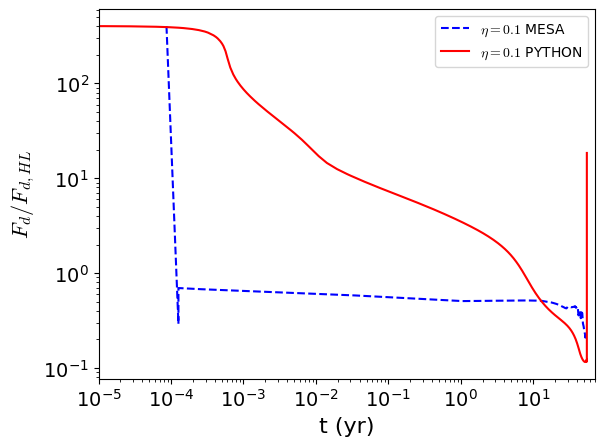

In [53]:
fd_hl = np.array([]) 
for i in range(j-1):
    fd_hl = np.append(fd_hl, p_arr[i].fd_hl[h.azone[i]])

fd = np.array([])
for i in range(j-1):
    fd = np.append(fd, p_arr[i].fd[h.azone[i]])
plt.plot(age, fd/fd_hl, '--', c='blue', label = r'$\eta = 0.1$ MESA') 

plt.xlim([0.00001,70])
plt.plot(t2_new_M2/yr_to_s, np.flip(drag2_new_M2/draghl_new_M2)[i_new_M2+1:f_new_M2], 'r', label = r'$\eta = 0.1$ PYTHON')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (yr)', fontsize=16)
plt.ylabel('$F_d/F_{d,HL}$', fontsize=16)
plt.legend()
plt.savefig('pictures/report/fd_vs_age.png', bbox_inches='tight')
plt.show()
plt.close()

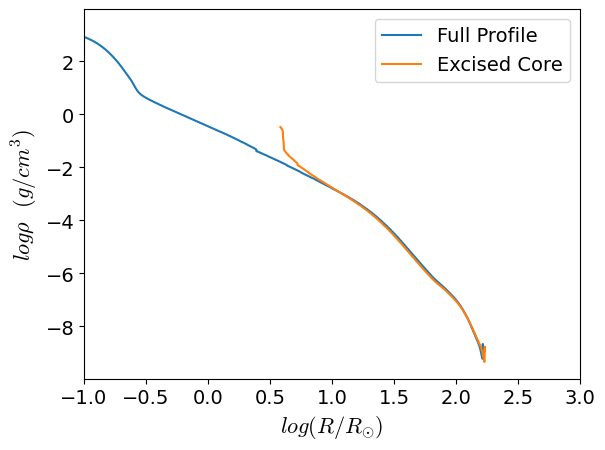

In [47]:
plt.plot(new_M3.logR, new_M3.logRho, label = 'Full Profile')
plt.plot(new_M2.logR, new_M2.logRho, label = 'Excised Core')
plt.xlim(-1, 3)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel(r'$log(R/R_{\odot})$', fontsize = 16)
plt.ylabel(r'$log \rho$  $(g/cm^3)$', fontsize = 16)
plt.legend(fontsize = 14)
plt.savefig('pictures/report/density_profile.png', bbox_inches='tight')
plt.show()
plt.close()

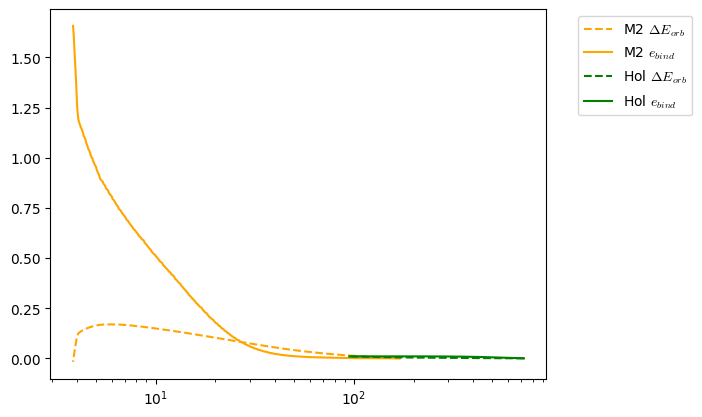

In [9]:
plt.plot(np.flip(R_new_M2)[i_new_M2:f_new_M2]/R_sun, np.flip(delta_eorb_new_M2)[i_new_M2:f_new_M2]/1e49, '--', c='orange', label = r'M2 $\Delta E_{orb}$')
plt.plot(np.flip(R_new_M2)[i_new_M2:f_new_M2]/R_sun, np.flip(-etot_int_new_M2)[i_new_M2:f_new_M2]/1e49, '-', c='orange', label = r'M2 $e_{bind}$')
plt.plot(np.flip(R_hol)[i_hol:f_hol]/R_sun, np.flip(delta_eorb_hol)[i_hol:f_hol]/1e49, '--', c='green', label = r'Hol $\Delta E_{orb}$')
plt.plot(np.flip(R_hol)[i_hol:f_hol]/R_sun, np.flip(-etot_int_hol)[i_hol:f_hol]/1e49, '-', c='green', label = r'Hol $e_{bind}$')
plt.legend()
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
plt.close()

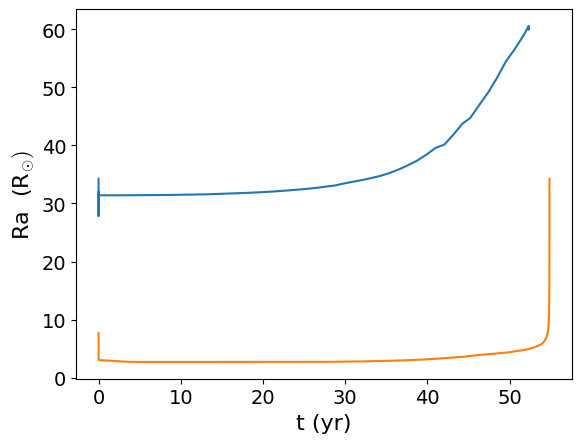

In [50]:
Ra = np.array([])
for i in range(j-1):
    Ra = np.append(Ra, p_arr[i].Ra[h.azone[i]]/R_sun)
plt.plot(age, Ra, label = r'$Ra$') 
plt.plot(t2_new_M2/yr_to_s, Ra_new_M2[1:]/R_sun)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('t (yr)', fontsize=16)
plt.ylabel(r'Ra  (R$_{\odot})$', fontsize=16)
plt.savefig('pictures/report/MESA_Ra_vs_age.png')

In [ ]:
plt.plot(R_new_M2/R_sun, mdotratio_new_M2, linestyle='--', c='blue', label = r'$\dot{M}/\dot{M}_{HL}: 12M_{\odot}$: Python')
plt.plot(R_new_M2/R_sun, dragratio_new_M2, linestyle='-', c='blue', label = r'$\dot{F_d}/\dot{F}_{HL}: 12M_{\odot}$: Python')
# plt.plot(R_new_M3/R_sun, mdotratio_new_M3, linestyle='--', c='b', label = r'$\dot{M}/\dot{M}_{HL}: 12M_{\odot}$: M3')
# plt.plot(R_new_M3/R_sun, dragratio_new_M3, linestyle='-', c='b', label = r'$\dot{F_d}/\dot{F}_{HL}: 12M_{\odot}$: M3')
# plt.plot(R_hol/R_sun, mdotratio_hol, linestyle='--', c='green', label = r'$\dot{M}/\dot{M}_{HL}: 12M_{\odot}$: Holgado profile')
# plt.plot(R_hol/R_sun, dragratio_hol, linestyle='-', c='green', label = r'$\dot{F_d}/\dot{F}_{HL}: 12M_{\odot}$: Holgado profile')
# plt.ylim([0.005, 1000])
plt.yscale('log')
plt.xlim([8, 400])
plt.legend(loc='upper left')
plt.xlabel(r'$r/R_{\odot}$')
plt.ylabel(r'Accretion and Drag Ratios')
plt.xscale('log')
plt.show()
plt.close()

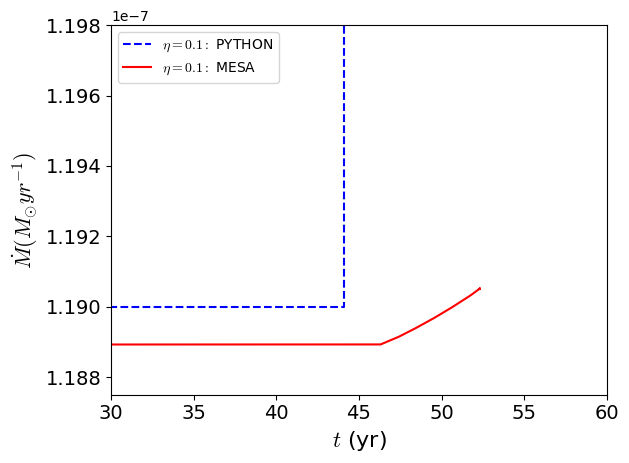

In [43]:
fig, ax1 = plt.subplots()
ax1.plot(t2_new_M2*s_to_yr, np.flip(mdot2_new_M2)[i_new_M2+1:f_new_M2]*yr_to_s/M_sun, linestyle = '--', c = 'b', label = r'$\eta = 0.1:$ PYTHON')
mdot = np.array([])
for i in range(j-1):
    mdot = np.append(mdot, p_arr[i].mdot[h.azone[i]]*yr_to_s/M_sun)
plt.plot(age, mdot, 'r', label = r'$\eta = 0.1:$ MESA') 
ax1.set_xlim(30, 60)
ax1.set_ylim(1.1875*10**-7,1.198*10**-7)
ax1.set_xlabel(r'$t$ (yr)', fontsize=16)
ax1.set_ylabel(r'$\dot{M} (M_{\odot} yr^{-1})$', fontsize=16)
ax1.legend(fontsize=10, loc='upper left')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
plt.savefig('pictures/report/mdot.png', bbox_inches='tight')
plt.show()
plt.close()

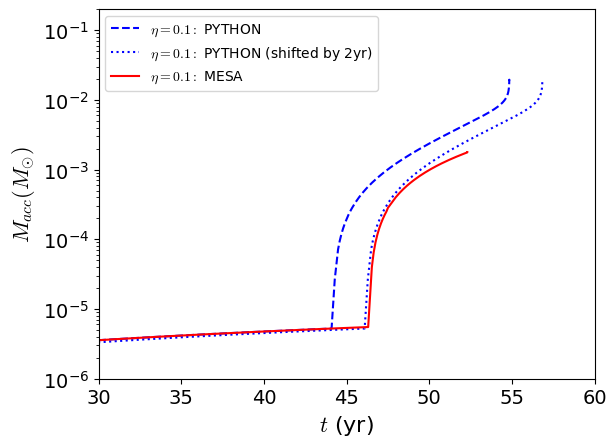

In [66]:
M_acc = h.M_ns - h.M_ns[0]
plt.plot(t2_new_M2[1:]*s_to_yr, m_acc2_new_M2/M_sun, linestyle = '--', c = 'b', label = r'$\eta = 0.1:$ PYTHON')
plt.plot(t2_new_M2[1:]*s_to_yr + 2, m_acc2_new_M2/M_sun, 'b', linestyle = 'dotted', label = r'$\eta = 0.1:$ PYTHON (shifted by 2yr)')
plt.plot(h.star_age, M_acc/M_sun, linestyle = '-', c = 'red', label = r'$\eta = 0.1:$ MESA')
plt.xlim(30, 60)
plt.ylim([1.e-6, 2.e-1])
plt.xlabel(r'$t$ (yr)', fontsize=16)
plt.ylabel(r'$M_{acc} (M_{\odot})$', fontsize=16)
plt.legend( fontsize=10, loc='upper left')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.yscale('log')
plt.savefig('pictures/report/Macc.png', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(t1_new_M2*s_to_yr, np.flip(delta_eorb_new_M2)[i_new_M2+1:f_new_M2], linestyle = '-', c = 'orange', label = r'$\eta = 1:$ M2')
ax1.plot(t1_new_M2*s_to_yr, np.flip(-etot_int_new_M2)[i_new_M2+1:f_new_M2], linestyle = '-', c = 'black')
ax1.plot(t2_new_M2*s_to_yr, np.flip(delta_eorb_new_M2)[i_new_M2+1:f_new_M2], linestyle = '--', c = 'orange', label = r'$\eta = 0.1:$ M2')
ax1.plot(t2_new_M2*s_to_yr, np.flip(-etot_int_new_M2)[i_new_M2+1:f_new_M2], linestyle = '-', c = 'black')
ax1.plot(t1_hol*s_to_yr, np.flip(delta_eorb_hol)[i_hol+1:f_hol], linestyle = '-', c = 'green', label = r'$\eta = 1:$ Holgado Profile')
ax1.plot(t1_hol*s_to_yr, np.flip(-etot_int_hol)[i_hol+1:f_hol], linestyle = '-', c = 'black')
ax1.plot(t2_hol*s_to_yr, np.flip(delta_eorb_hol)[i_hol+1:f_hol], linestyle = '--', c = 'green', label = r'$\eta = 0.1:$ Holgado Profile')
ax1.plot(t2_hol*s_to_yr, np.flip(-etot_int_hol)[i_hol+1:f_hol], linestyle = '-', c = 'black', label = r'$E_{env}$')

ax1.set_xlim(0.1, 100)
ax1.set_ylim(1.e45, 1.e49)
ax1.set_xlabel(r'$t$ (yr)', fontsize=16)
ax1.set_ylabel(r'Energy: $E$ (erg)', fontsize=16)
plt.legend(fontsize=8, loc = 'upper center')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
plt.show()
plt.close()


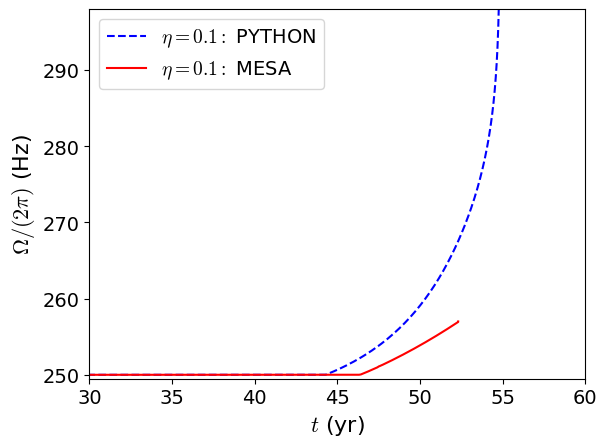

In [55]:
plt.plot(t2_new_M2*s_to_yr, omega2_new_M2/(2*np.pi), linestyle = '--', c = 'blue', label = r'$\eta = 0.1:$ PYTHON')
plt.plot(h.star_age, h.omega/(2*np.pi), 'red', label = r'$\eta = 0.1:$ MESA')
plt.legend(fontsize = 14)
plt.xlabel(r'$t$ (yr)', fontsize = 16)
plt.ylabel(r'$\Omega/(2 \pi)$ (Hz)', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlim([30, 60])
plt.ylim([249.5, 298])
plt.savefig('pictures/report/omega.png', bbox_inches='tight')
plt.show()
plt.close()

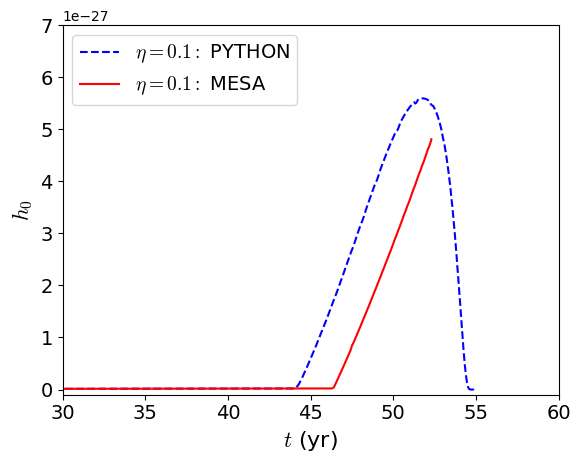

In [58]:
h_signal= 2*G_const*(h.omega**2)*(h.Q)/(D*c**4)

plt.plot(t2_new_M2*s_to_yr, h0_2_new_M2, linestyle = '--', c = 'b', label = r'$\eta = 0.1:$ PYTHON')
plt.plot(h.star_age[1:], h_signal[1:], 'red', label = r'$\eta = 0.1:$ MESA')
plt.legend(fontsize=14)
plt.xlabel(r'$t$ (yr)', fontsize=16)
plt.ylabel(r'$h_0$', fontsize=16)
plt.xlim([30, 60])
plt.ylim([-0.1e-27,7e-27])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('pictures/report/h0.png', bbox_inches='tight')
plt.show()
plt.close()

plt.plot(beta_from_e, elip, label = r'$n = 0.5$')
plt.plot(beta_sec, elip, linestyle = '--', c = 'black', label = r'$\beta = \beta_{sec} = 0.14$')
plt.xlim([-0.01, 0.4])
plt.legend()
plt.xlabel(r'Spin Parameter: $\beta = T/|W|$')
plt.ylabel(r'Spin Frequency: $f_s = \Omega/(2 \pi)$ [Hz]')
plt.show()
plt.close()

plt.plot(R_b20/R_sun, delta_eorb_b20)
plt.plot(R_b20/R_sun, -etot_int_b20, c = 'r')
plt.xscale('log')
plt.show()
plt.close()

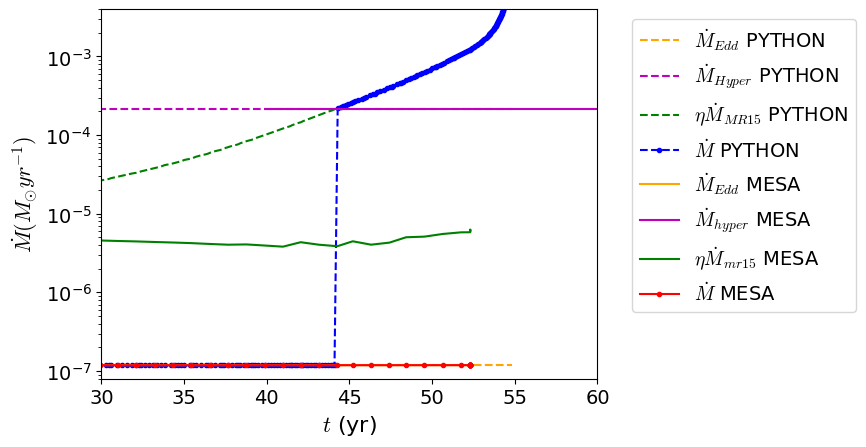

In [46]:
plt.plot(t2_new_M2*s_to_yr, np.flip(mdot_edd_new_M2)[i_new_M2+1:f_new_M2]*yr_to_s/M_sun, '--', c = 'orange', label = r'$\dot{M}_{Edd}$ PYTHON')
plt.plot(t2_new_M2*s_to_yr, np.flip(mdot_hyper_new_M2)[i_new_M2+1:f_new_M2]*yr_to_s/M_sun, '--', c = 'm', label = r'$\dot{M}_{Hyper}$ PYTHON')
plt.plot(t2_new_M2*s_to_yr, np.flip(eta2*mdotmr15_new_M2)[i_new_M2+1:f_new_M2]*yr_to_s/M_sun, '--', c='g', label = r'$\eta \dot{M}_{MR15}$ PYTHON')
plt.plot(t2_new_M2*s_to_yr, np.flip(mdot2_new_M2)[i_new_M2+1:f_new_M2]*yr_to_s/M_sun, '--', marker = '.', c = 'b', label = r'$\dot{M}$ PYTHON')

mdot_edd = 3.5*(10**(-8))*(h.M_ns/(1.33*M_sun))*(0.34/0.1)
mdot_hyper = 8.9*(10**(-5))*((0.1/0.34)**(-0.73))
x_hyper = np.linspace(40, 60, 100)
y_hyper = np.repeat(mdot_hyper, 100)

plt.plot(h.star_age, mdot_edd, c = 'orange', label = r'$\dot{M}_{Edd}$ MESA')
plt.plot(x_hyper, y_hyper, c = 'm', label = r'$\dot{M}_{hyper}$ MESA')

mdot_mr15 = np.array([])
for i in range(j-1):
    mdot_mr15 = np.append(mdot_mr15, 0.1*p_arr[i].mdot_mr15[h.azone[i]]*yr_to_s/M_sun)
plt.plot(age, mdot_mr15, c = 'g', label = r'$\eta \dot{M}_{mr15}$ MESA')

mdot = np.array([])
for i in range(j-1):
    mdot = np.append(mdot, p_arr[i].mdot[h.azone[i]]*yr_to_s/M_sun)
plt.plot(age, mdot, c = 'r', marker = '.', label = r'$\dot{M}$ MESA') 

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize = 14)
plt.xlim([30,60])
plt.ylim([8e-8, 4e-3])
plt.xlabel(r'$t$ (yr)', fontsize=16)
plt.ylabel(r'$\dot{M} (M_{\odot} yr^{-1})$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xscale('log')
plt.yscale('log')
plt.savefig('pictures/report/mdot_all.png', bbox_inches='tight')
plt.show()
plt.close()

# plt.xlim([0.1, 300])

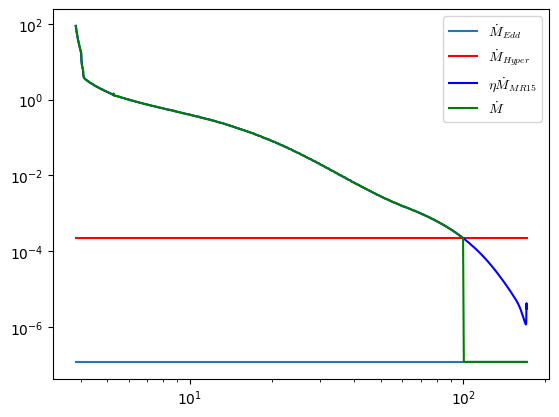

In [ ]:
plt.plot(R_new_M2/R_sun, mdot_edd_new_M2*yr_to_s/M_sun, label = r'$\dot{M}_{Edd}$')
plt.plot(R_new_M2/R_sun, mdot_hyper_new_M2*yr_to_s/M_sun, c = 'r', label = r'$\dot{M}_{Hyper}$')
plt.plot(R_new_M2/R_sun, eta2*mdotmr15_new_M2*yr_to_s/M_sun, c='b', label = r'$\eta \dot{M}_{MR15}$')
plt.plot(R_new_M2/R_sun, mdot2_new_M2*yr_to_s/M_sun, c = 'g', label = r'$\dot{M}$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close()

In [ ]:
plt.plot(R_new_M2/R_sun, rho_new_M2, linestyle='-', c='orange', label = r'$12M_{\odot}$: M2')
plt.plot(R_new_M3/R_sun, rho_new_M3, linestyle='-', c='b', label = r'$12M_{\odot}$: M3')
plt.plot(R_hol/R_sun, rho_hol, linestyle='-', c='g', label = r'$12M_{\odot}$: Holgado Profile')
# plt.xlim([0.1,4000])
# plt.ylim([1e-10, 1e2])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$r/R_{\odot}$')
plt.ylabel(r'$\rho (g cm^{-2})$')
plt.xscale('log')
plt.show()
plt.close()

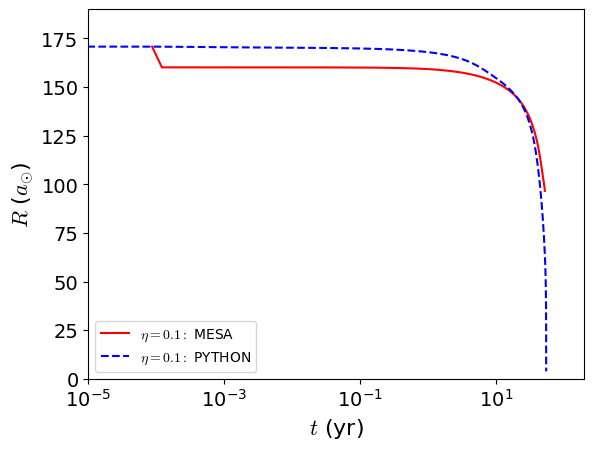

In [54]:
fig, ax1 = plt.subplots()
plt.plot(h.star_age, h.a_curr/(6.957*(10**10)), 'r', label = r'$\eta = 0.1:$ MESA')
ax1.plot(t2_new_M2*s_to_yr, np.flip(R_new_M2)[i_new_M2+1:f_new_M2]/R_sun, linestyle = '--', c = 'b', label = r'$\eta = 0.1:$ PYTHON')

ax1.set_xlim(0.00001, 200)
ax1.set_ylim(0, 190)
ax1.set_xlabel(r'$t$ (yr)', fontsize = 16)
ax1.set_ylabel(r'$R$ ($a_{\odot}$)', fontsize = 16)
ax1.legend(fontsize = 10)
ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
plt.savefig('pictures/report/orbital_separation.png', bbox_inches='tight')
plt.show()
plt.close()

#IMPORTANT!!!!!!! DO NOT DELETE

#######################################################################################################################

#TIP12

#eddington and hyper accretion rates
mdot_edd_t12 = mdot_edd(opacity_t12)
mdot_hyper_t12 = mdot_hyper(opacity_t12)

#epsilon rho
v_t12 = v_inf(m_t12, R_t12)
Ra_t12 = 2*G_const*M_ns/v_t12**2
eps_rho_t12 = Ra_t12/scl_hgt_t12

#drag mr15
fdhl_t12 = drag_hl(Ra_t12, rho_t12, v_t12)
fdratio_t12 = drag_ratio_mr15(eps_rho_t12)
fdmr15_t12 = fdhl_t12*fdratio_t12

#accretion mr15
mdothl_t12 = acc_hl(Ra_t12, rho_t12, v_t12)
mdotratio_t12 = acc_rate_ratio_mr15(eps_rho_t12)
mdotmr15_t12 = mdothl_t12*mdotratio_t12

#orbital energy
eorb_t12 = e_orbital(m_t12, R_t12)
deorb_t12 = diff1d(eorb_t12, R_t12)

#accretion rate parametrization
mdot1_t12, ind_btw1_t12 = mdot_compare(mdotmr15_t12, eta1, mdot_edd_t12, mdot_hyper_t12)
mdot2_t12, ind_btw2_t12 = mdot_compare(mdotmr15_t12, eta2, mdot_edd_t12, mdot_hyper_t12)

#drag
drag1_t12 = mdot1_t12*v_t12
drag2_t12 = mdot2_t12*v_t12

#sound
sound_speed_sq_t12 = diff1d(10**t12.logP, 10**t12.logRho)
sound_speed_sq_t12[np.where(sound_speed_sq_t12<0)] = sound_speed_sq_t12[np.where(sound_speed_sq_t12<0)[0][0]-1]
sound_speed_t12 = np.sqrt(sound_speed_sq_t12)

#orbital evolution
print(len(eorb_t12), len(etot_int_t12), len(drag1_t12), len(v_t12), len(R_t12), len(deorb_t12))
i_t12 = 0
f_t12 = 370
t1_t12 = orbit_evol(np.flip(eorb_t12), np.flip(-etot_int_t12), np.flip(drag1_t12), np.flip(v_t12), np.flip(R_t12), np.flip(deorb_t12), i_t12, f_t12)

#######################################################################################################################

#BASE20

#epsilon rho
m_b20 = mass_env(rho_b20, R_b20)
v_b20 = v_inf(m_b20, R_b20[1:])
Ra_b20 = 2*G_const*M_ns/v_b20**2
eps_rho_b20 = Ra_b20/scl_hgt_b20[1:]

#drag mr15
fdhl_b20 = drag_hl(Ra_b20, rho_b20[1:], v_b20)
fdratio_b20 = drag_ratio_mr15(eps_rho_b20)
fdmr15_b20 = fdhl_b20*fdratio_b20

#accretion mr15
mdothl_b20 = acc_hl(Ra_b20, rho_b20[1:], v_b20)
mdotratio_b20 = acc_rate_ratio_mr15(eps_rho_b20)
mdotmr15_b20 = mdothl_b20*mdotratio_b20

#orbital energy
eorb_b20 = e_orbital(m_b20, R_b20[1:])
deorb_b20 = diff1d(eorb_b20, R_b20[1:])

#accretion rate parametrization
mdot1_b20, ind_btw1_b20 = mdot_compare(mdotmr15_b20, eta1)
mdot2_b20, ind_btw2_b20 = mdot_compare(mdotmr15_b20, eta2)

#drag
drag1_b20 = mdot1_b20*v_b20
drag2_b20 = mdot2_b20*v_b20

#######################################################################################################################

#TIP20

#epsilon rho
m_t20 = mass_env(rho_t20, R_t20)
v_t20 = v_inf(m_t20, R_t20[1:])
Ra_t20 = 2*G_const*M_ns/v_t20**2
eps_rho_t20 = Ra_t20/scl_hgt_t20[1:]

#drag mr15
fdhl_t20 = drag_hl(Ra_t20, rho_t20[1:], v_t20)
fdratio_t20 = drag_ratio_mr15(eps_rho_t20)
fdmr15_t20 = fdhl_t20*fdratio_t20

#accretion mr15
mdothl_t20 = acc_hl(Ra_t20, rho_t20[1:], v_t20)
mdotratio_t20 = acc_rate_ratio_mr15(eps_rho_t20)
mdotmr15_t20 = mdothl_t20*mdotratio_t20

#orbital energy
eorb_t20 = e_orbital(m_t20, R_t20[1:])
deorb_t20 = diff1d(eorb_t20, R_t20[1:])

#accretion rate parametrization
mdot1_t20, ind_btw_t20 = mdot_compare(mdotmr15_t20, eta1)
mdot2_t20, ind_btw2_t20 = mdot_compare(mdotmr15_t20, eta2)

#drag
drag1_t20 = mdot1_t20*v_t20
drag2_t20 = mdot2_t20*v_t20